In [1]:
#library(tidyverse)
suppressMessages({
    library(MOFA2)
    library(ggplot2)
    library(cowplot)
    library(data.table)
    library(purrr)
    library(reticulate)
    library(Seurat)
    library(Signac)
    library(MOFA2)
    library(ggpubr)
    library(msigdbr)
    library(ggbio)
    library(magrittr)
    library(psych)
})

Warning message:
“no function found corresponding to methods exports from ‘HDF5Array’ for: ‘write_sparse_block’”


In [10]:
sortedMOFA     <- MOFA2::load_model("../data/3k_sorted_trained_mofa.rds", remove_inactive_factors = F)
unsortedMOFA   <- MOFA2::load_model("../data/3k_unsorted_trained_mofa.rds", remove_inactive_factors = F)
sortedSeurat   <- readRDS("../data/3k_sorted_seurat.rds")
unsortedSeurat <- readRDS("../data/3k_unsorted_seurat.rds")

Warning message in quality_control(object, verbose = verbose):
"Factor(s) 1, 2 are strongly correlated with the total number of expressed features for at least one of your omics. Such factors appear when there are differences in the total 'levels' between your samples, *sometimes* because of poor normalisation in the preprocessing steps.
"
Warning message in quality_control(object, verbose = verbose):
"Factor(s) 2 are strongly correlated with the total number of expressed features for at least one of your omics. Such factors appear when there are differences in the total 'levels' between your samples, *sometimes* because of poor normalisation in the preprocessing steps.
"


In [11]:
# ckeck if objects are generated/loaded correctly
head(sortedSeurat@meta.data[,c("celltype", "broad_celltype","pass_rnaQC","pass_accQC")])
head(unsortedSeurat@meta.data[,c("celltype", "broad_celltype","pass_rnaQC","pass_accQC")])

,celltype,broad_celltype,pass_rnaQC,pass_accQC
,<chr>,<chr>,<lgl>,<lgl>
AAACAGCCAAATATCC-1,NK cell,Lymphoid,TRUE,TRUE
AAACAGCCAGGAACTG-1,CD14+ Monocytes,Myeloid,TRUE,TRUE
AAACAGCCAGGCTTCG-1,CD14+ Monocytes,Myeloid,TRUE,TRUE
AAACCAACACCTGCTC-1,pre-B cell,Lymphoid,TRUE,TRUE
AAACCAACAGATTCAT-1,CD8 effector,Lymphoid,TRUE,TRUE
AAACCAACAGTTGCGT-1,CD4 Naive,Lymphoid,TRUE,TRUE


,celltype,broad_celltype,pass_rnaQC,pass_accQC
,<chr>,<chr>,<lgl>,<lgl>
AAACAGCCAACAGGTG-1,CD4 Naive,Lymphoid,TRUE,TRUE
AAACATGCAACAACAA-1,CD14+ Monocytes,Myeloid,TRUE,TRUE
AAACATGCACCTGGTG-1,CD4 Memory,Lymphoid,TRUE,TRUE
AAACCAACACAGCCTG-1,CD4 Naive,Lymphoid,TRUE,TRUE
AAACCAACAGCAAGAT-1,CD4 Memory,Lymphoid,TRUE,TRUE
AAACCAACATTGCGAC-1,CD4 Naive,Lymphoid,TRUE,TRUE


In [12]:
table(sortedSeurat@meta.data$celltype)
table(sortedSeurat@meta.data$broad_celltype)
table(unsortedSeurat@meta.data$celltype)
table(unsortedSeurat@meta.data$broad_celltype)


     B cell progenitor        CD14+ Monocytes        CD16+ Monocytes 
                   109                    787                    109 
            CD4 Memory              CD4 Naive           CD8 effector 
                   483                    448                    179 
             CD8 Naive         Dendritic cell Double negative T cell 
                   303                     41                     18 
               NK cell                    pDC             pre-B cell 
                   115                     28                     94 


Lymphoid  Myeloid 
    1818      896 


     B cell progenitor        CD14+ Monocytes        CD16+ Monocytes 
                   152                    955                    115 
            CD4 Memory              CD4 Naive           CD8 effector 
                   471                    480                    182 
             CD8 Naive         Dendritic cell Double negative T cell 
                   306                     31                     34 
               NK cell                    pDC             pre-B cell 
                   112                     28                    146 


Lymphoid  Myeloid 
    1942     1070 

In [13]:
samples_metadata(sortedMOFA) <- sortedSeurat@meta.data %>%
  tibble::rownames_to_column("sample") %>%
  as.data.table
samples_metadata(unsortedMOFA) <- unsortedSeurat@meta.data %>%
  tibble::rownames_to_column("sample") %>%
  as.data.table

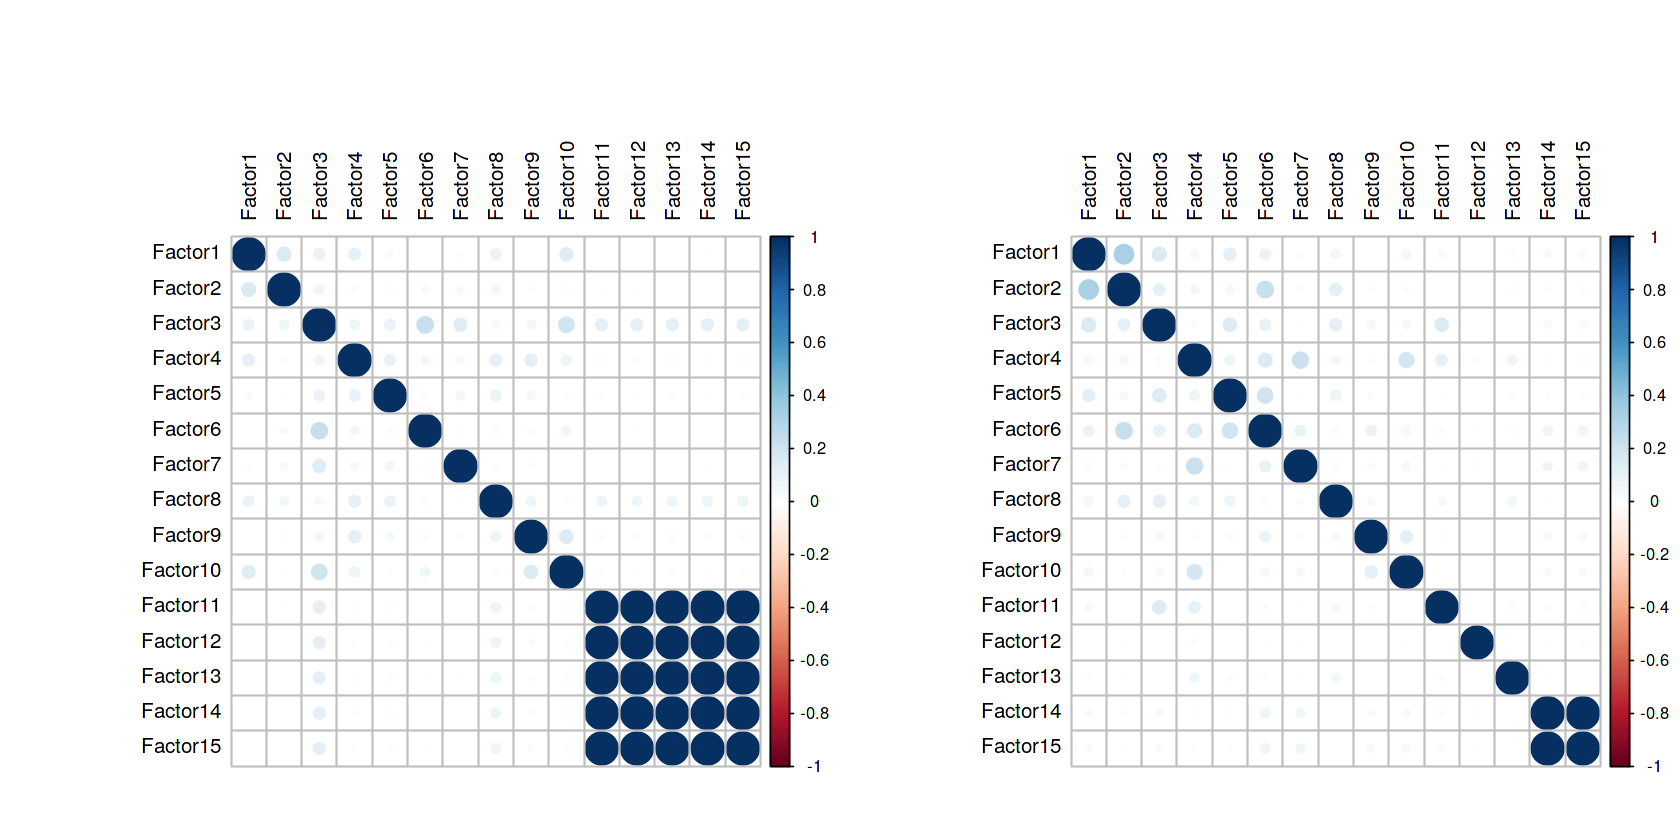

In [14]:
options(repr.plot.width = 14, repr.plot.height = 7)

par(mfrow = c(1,2))
MOFA2::plot_factor_cor(sortedMOFA)
MOFA2::plot_factor_cor(unsortedMOFA)

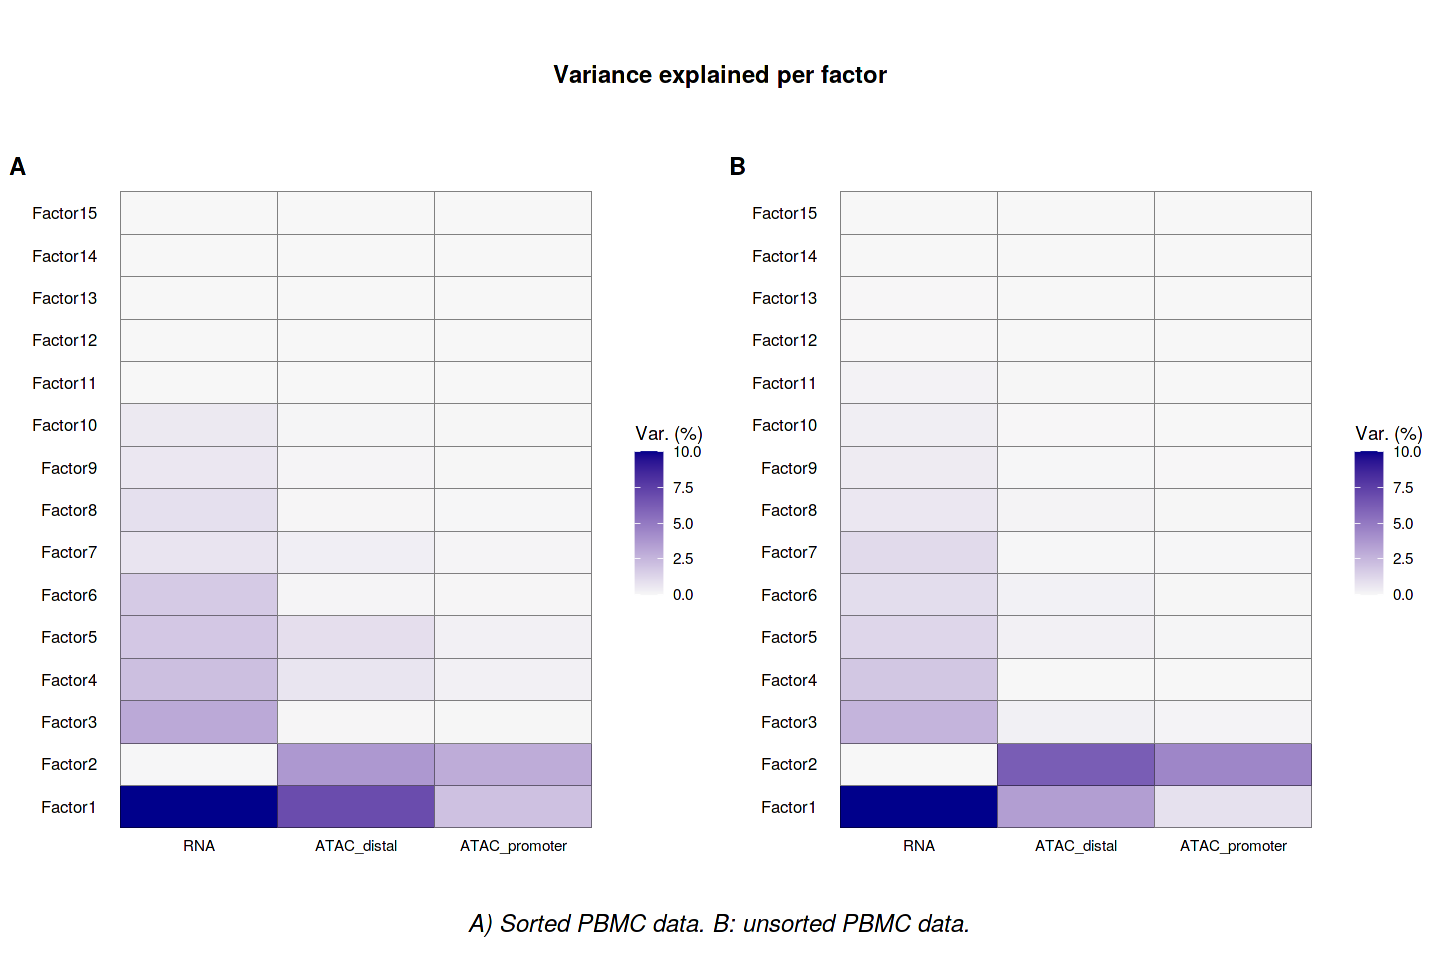

In [15]:
options(repr.plot.width = 12, repr.plot.height = 8)

a    <- MOFA2::plot_variance_explained(sortedMOFA, max_r2 = 10)
b    <- MOFA2::plot_variance_explained(unsortedMOFA, max_r2 = 10)
plot <- cowplot::plot_grid(a, b, labels = "AUTO", align = "h")


title   <- ggdraw() + draw_label(
    "Variance explained per factor",
    fontface = 'bold') 

caption <- ggdraw() + draw_label(
    "A) Sorted PBMC data. B: unsorted PBMC data.",
    fontface = 'italic') 

cowplot::plot_grid(title, plot, caption, ncol = 1, rel_heights = c(0.2, 1, 0.1))

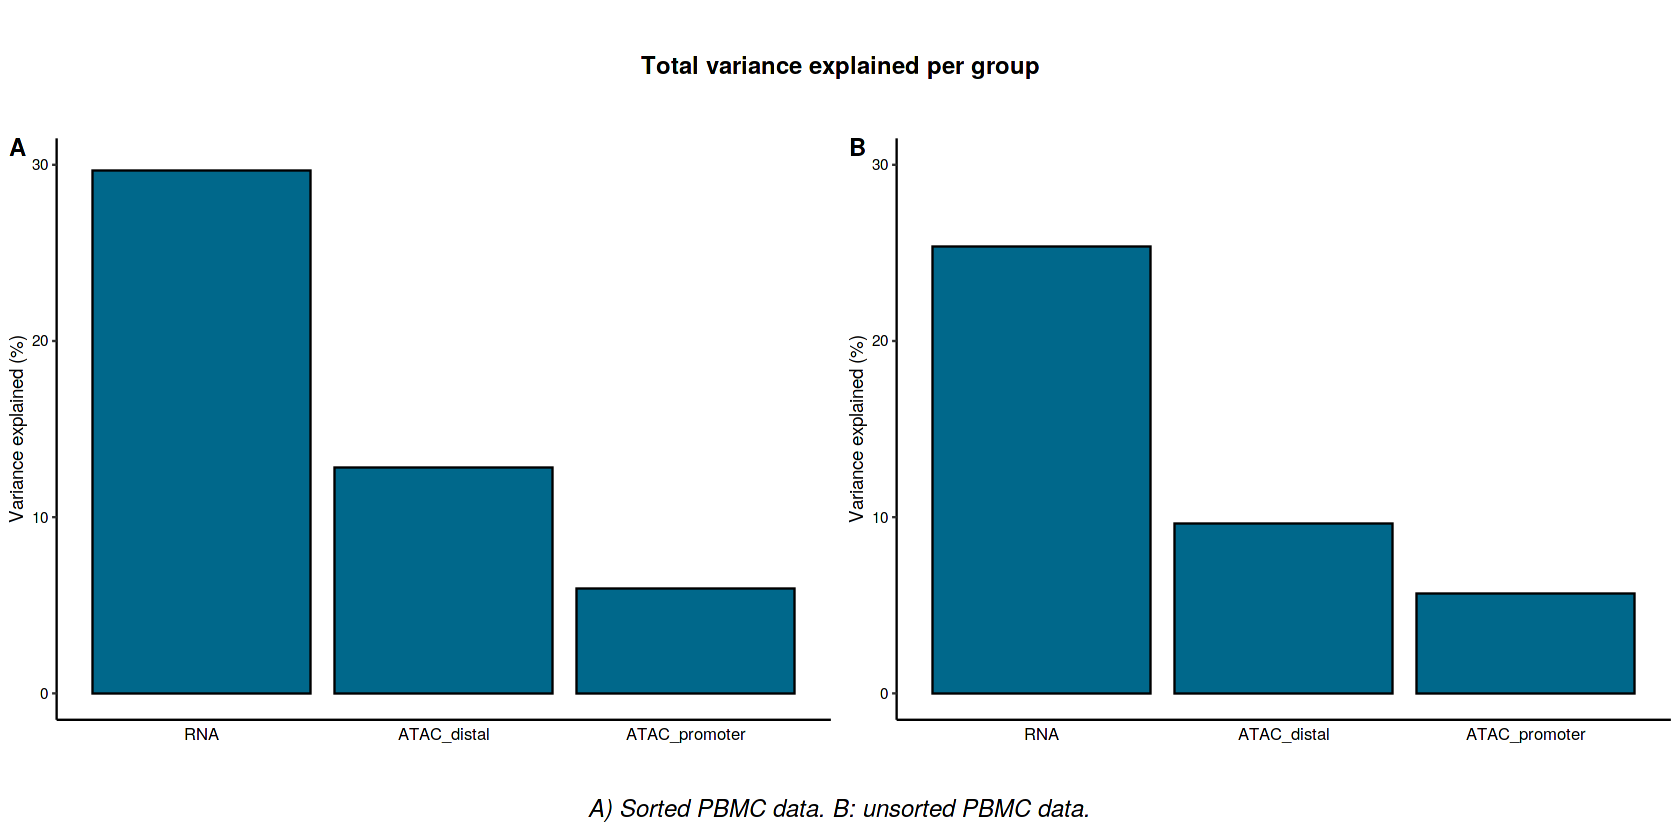

In [16]:
options(repr.plot.width = 14, repr.plot.height = 7)
suppressMessages({
    a <- MOFA2::plot_variance_explained(sortedMOFA,
                                 plot_total = TRUE)[[2]] +
         ylim(0, 30)

    b <- MOFA2::plot_variance_explained(unsortedMOFA,
                                 plot_total = TRUE)[[2]] +
         ylim(0, 30)
    plot <- cowplot::plot_grid(a, b, labels = "AUTO", align = "h")


    title   <- ggdraw() + draw_label(
        "Total variance explained per group",
        fontface = 'bold') 

    caption <- ggdraw() + draw_label(
        "A) Sorted PBMC data. B: unsorted PBMC data.",
        fontface = 'italic') 

    cowplot::plot_grid(title, plot, caption, ncol = 1, rel_heights = c(0.2, 1, 0.1))
})

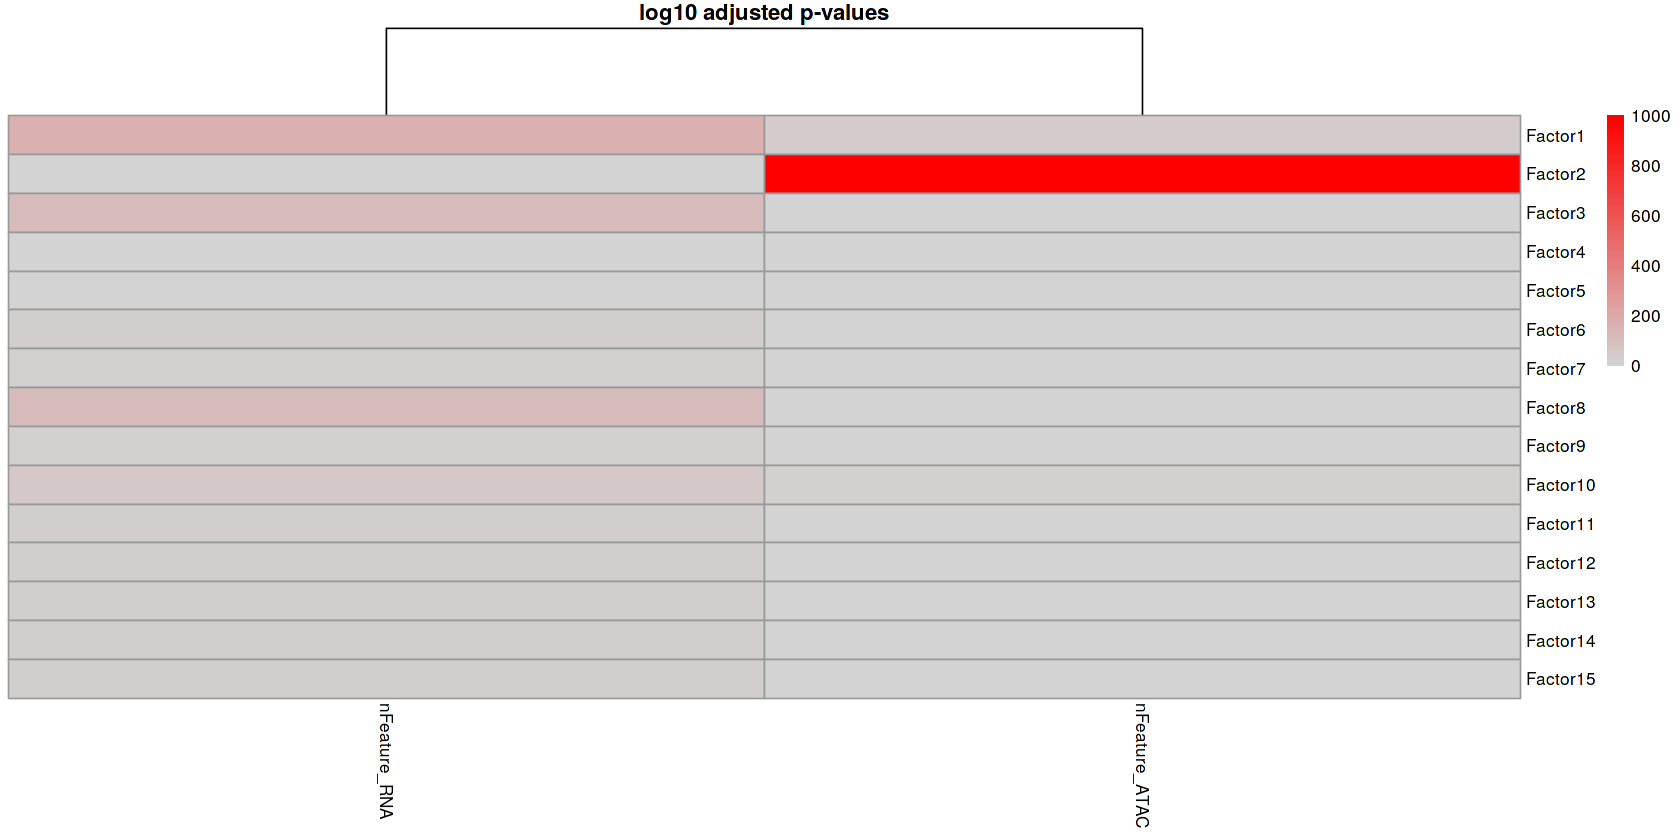

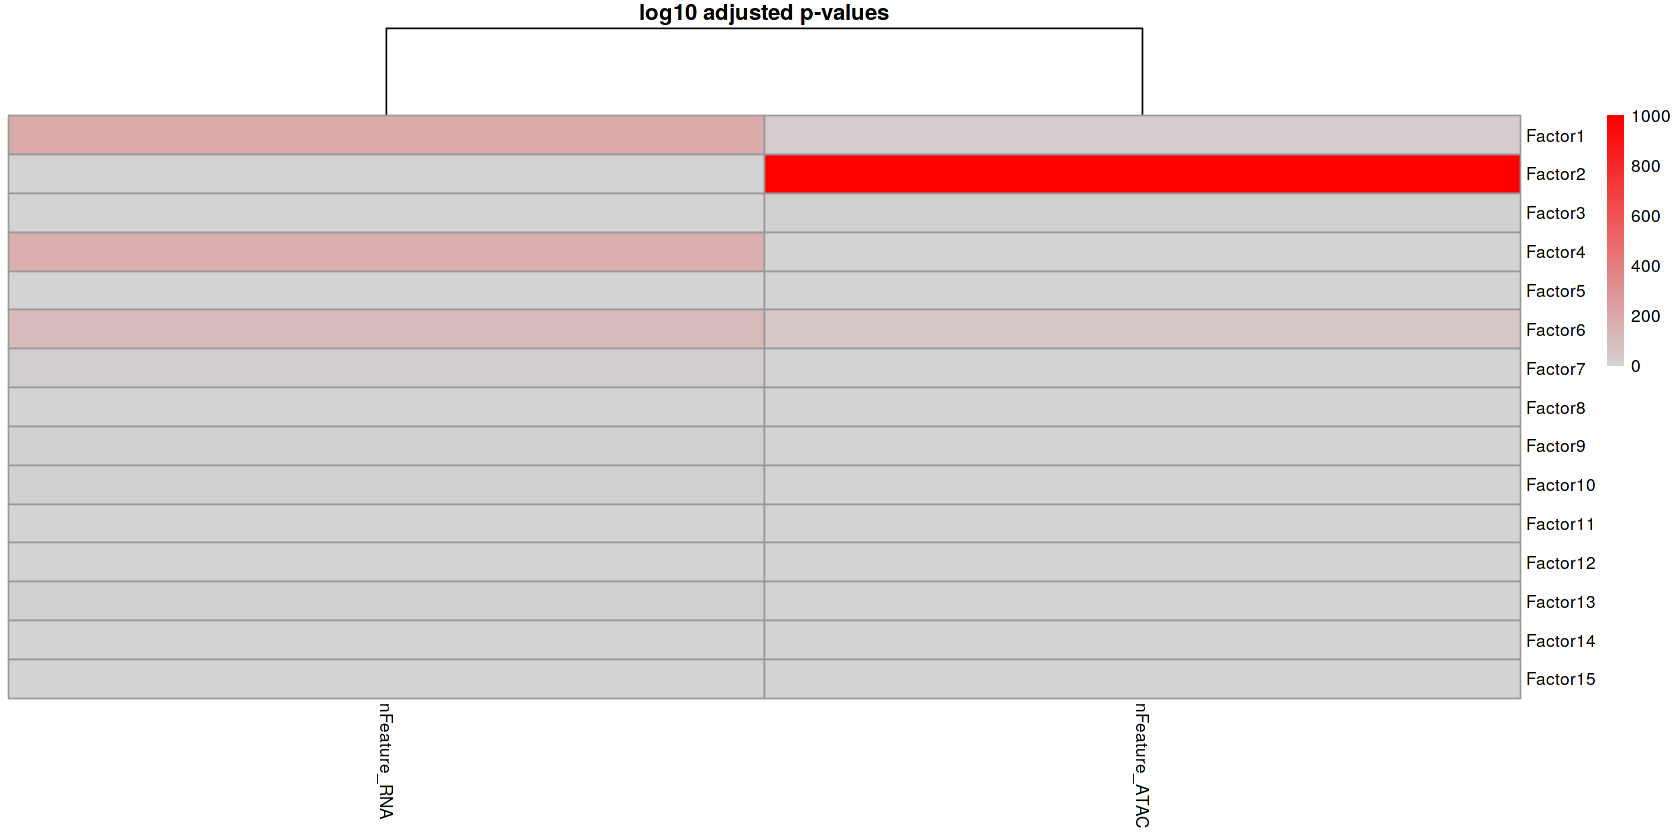

In [17]:
MOFA2::correlate_factors_with_covariates(sortedMOFA, 
  covariates = c("nFeature_RNA","nFeature_ATAC")
  )
MOFA2::correlate_factors_with_covariates(unsortedMOFA,
  covariates = c("nFeature_RNA","nFeature_ATAC")
  )

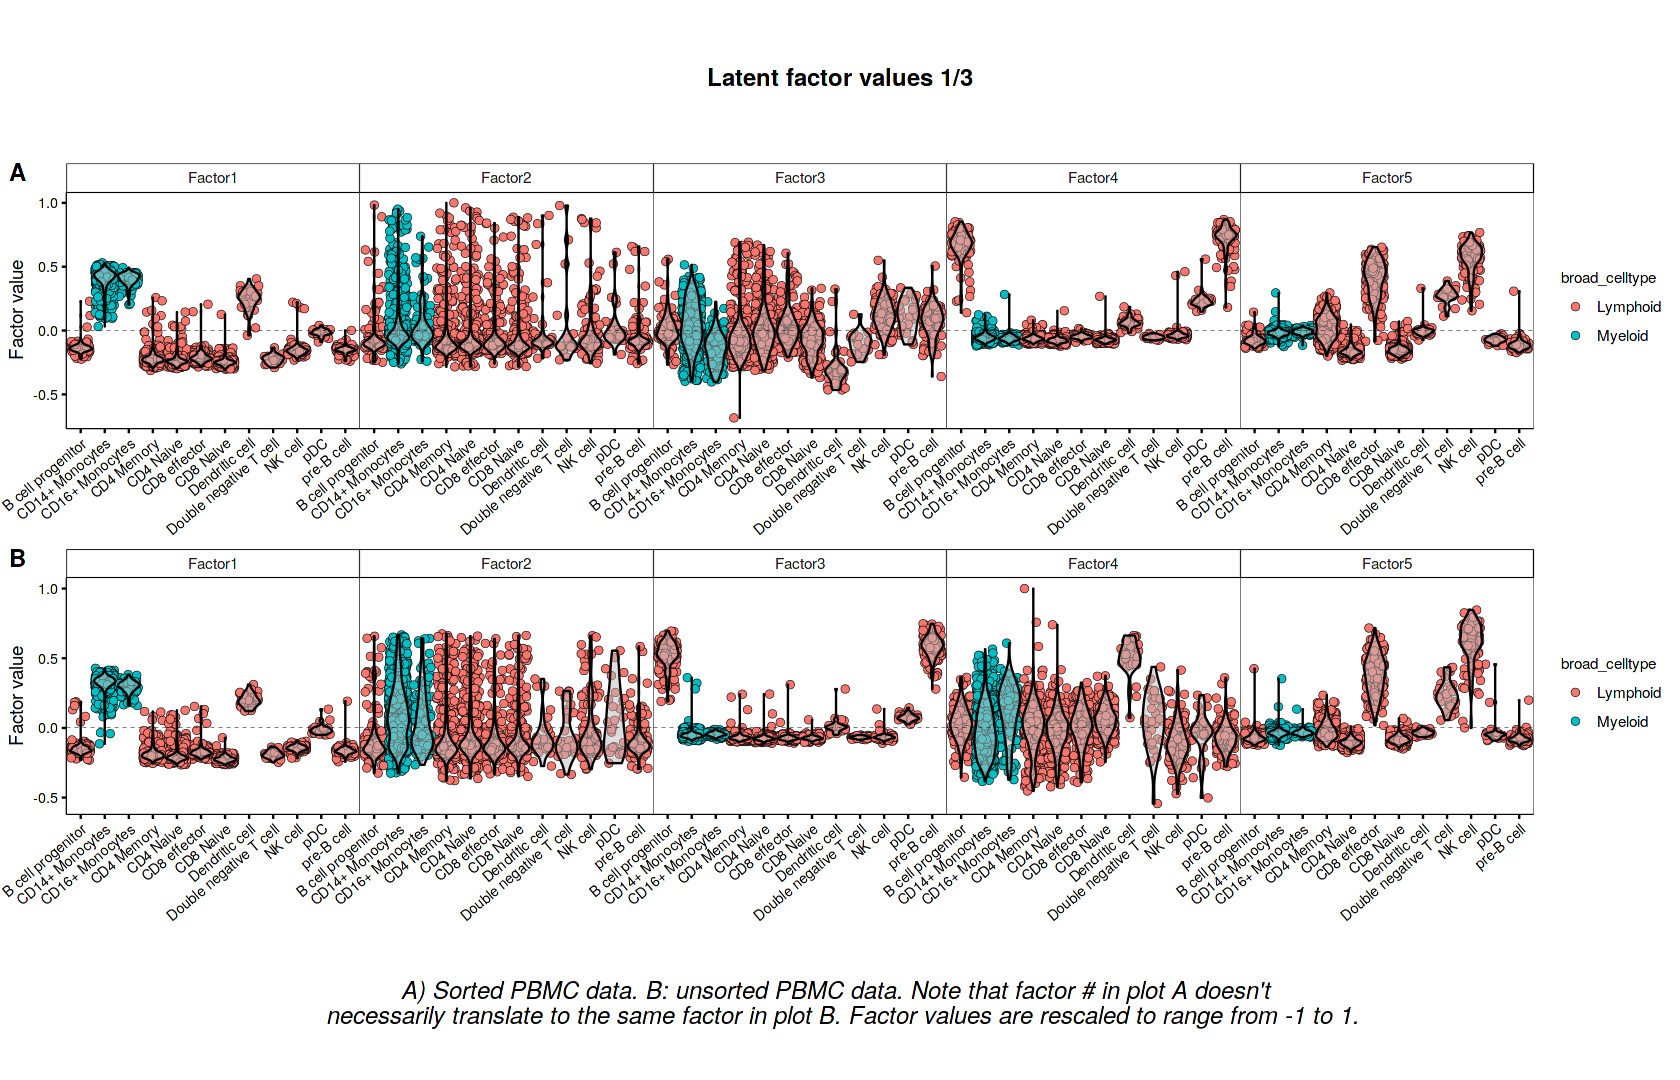

In [18]:
options(repr.plot.width = 14, repr.plot.height = 9)

fact <- c(1,2, 3, 4, 5)

a <- MOFA2::plot_factor(sortedMOFA,
                        factors=fact,
                        group_by = "celltype",
                        color_by = "broad_celltype",
                        add_violin = TRUE,
                        scale = TRUE) +
  theme(axis.text.x = element_text(color="black",
                                   angle=40,
                                   vjust=1,
                                   hjust=1))
b <- MOFA2::plot_factor(unsortedMOFA,
                        factors=fact,
                        group_by = "celltype",
                        color_by = "broad_celltype",
                        add_violin = TRUE,
                        scale = TRUE) +
  theme(axis.text.x = element_text(color="black",
                                   angle=40,
                                   vjust=1,
                                   hjust=1))
plot <- cowplot::plot_grid(a, b, labels = "AUTO", ncol = 1)

title   <- ggdraw() + draw_label(
    "Latent factor values 1/3",
    fontface = 'bold') 

caption <- ggdraw() + draw_label(
    "A) Sorted PBMC data. B: unsorted PBMC data. Note that factor # in plot A doesn't \n necessarily translate to the same factor in plot B. Factor values are rescaled to range from -1 to 1.",
    fontface = 'italic') 

cowplot::plot_grid(title, plot, caption, ncol = 1, rel_heights = c(0.2, 1, 0.2))

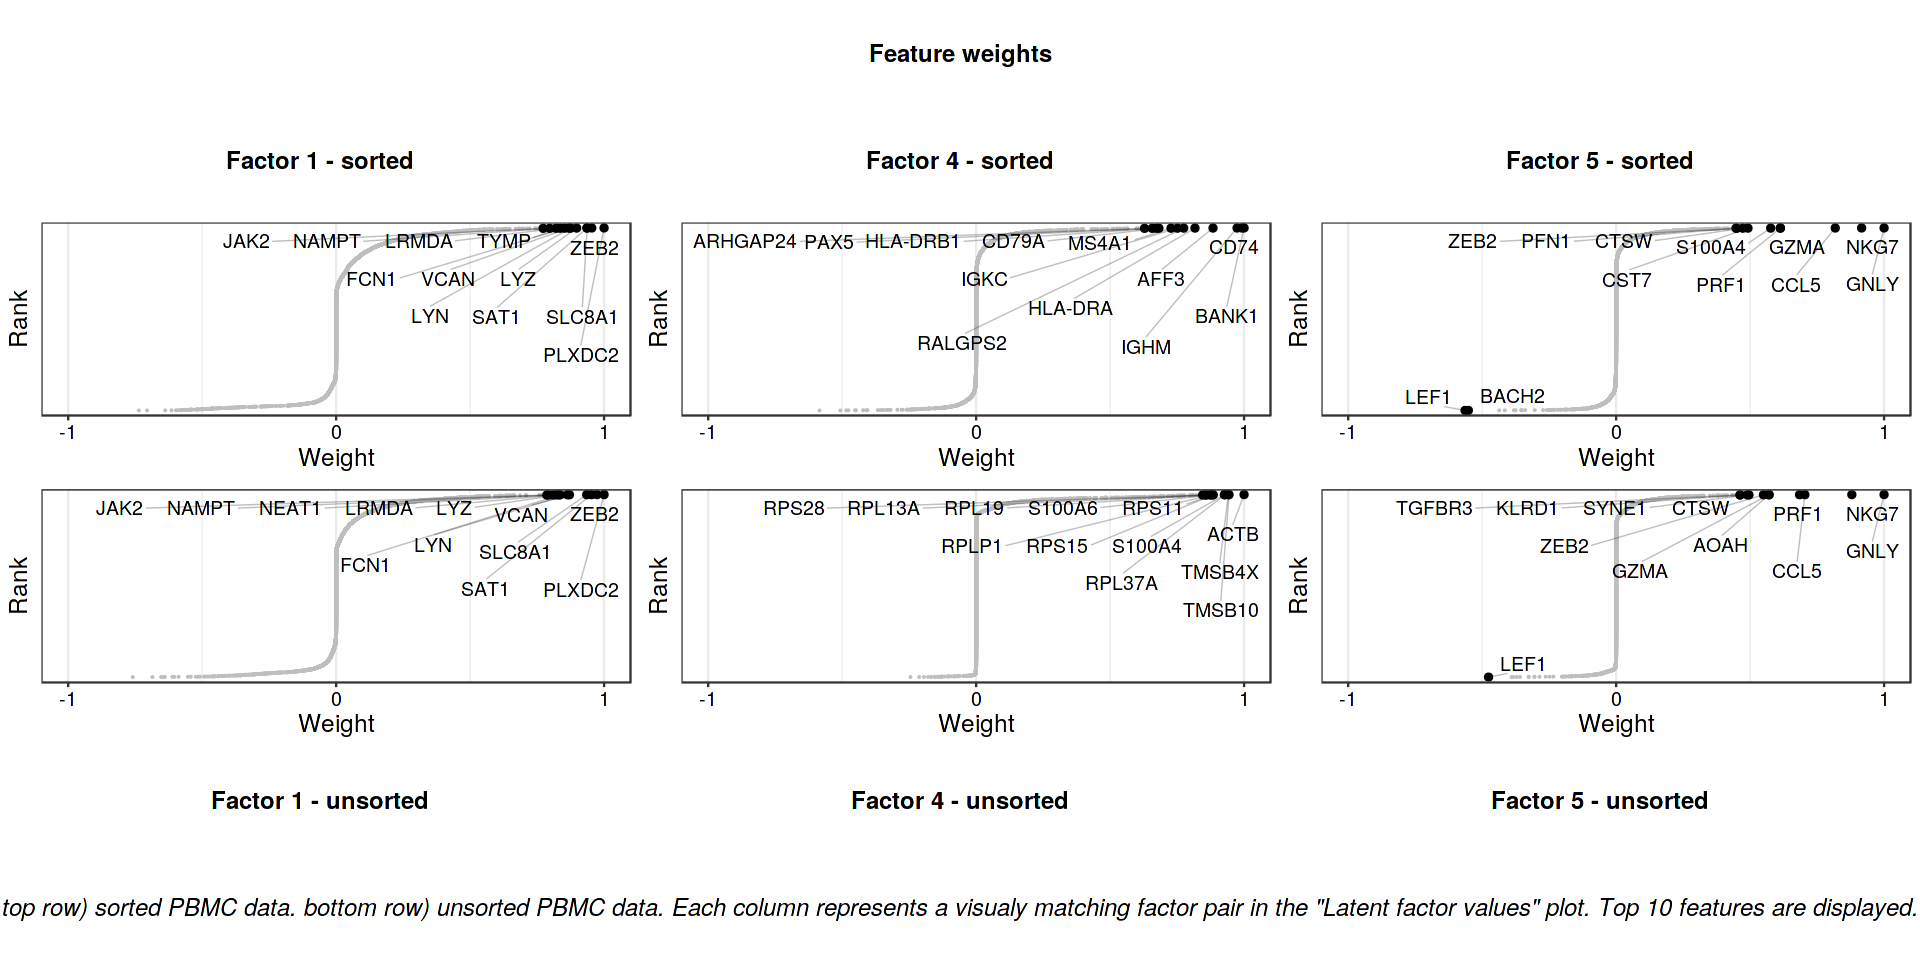

In [19]:
options(repr.plot.width = 16, repr.plot.height = 8)

a <- plot_weights(sortedMOFA, 
  view = "RNA", nfeatures = 12, text_size = 4,
  factors = 1)
b <- plot_weights(sortedMOFA, 
  view = "RNA", nfeatures = 12, text_size = 4,
  factors = 4)
c <- plot_weights(sortedMOFA, 
  view = "RNA", nfeatures = 12, text_size = 4,
  factors = 5)


g <- plot_weights(unsortedMOFA, 
  view = "RNA", nfeatures = 12, text_size = 4,
  factors = 1)
h <- plot_weights(unsortedMOFA, 
  view = "RNA", nfeatures = 12, text_size = 4,
  factors = 4)
i <- plot_weights(unsortedMOFA, 
  view = "RNA", nfeatures = 12, text_size = 4,
  factors = 5)


plot    <- cowplot::plot_grid(a, b, c, g, h, i, nrow = 2)

title   <- ggdraw() + draw_label(
    "Feature weights",
    fontface = 'bold') 

top_labels <- plot_grid(
    ggdraw() + draw_label("Factor 1 - sorted", fontface = 'bold'),
    ggdraw() + draw_label("Factor 4 - sorted", fontface = 'bold'),
    ggdraw() + draw_label("Factor 5 - sorted", fontface = 'bold'),
    nrow = 1
)

bottom_labels <- plot_grid(
    ggdraw() + draw_label("Factor 1 - unsorted", fontface = 'bold'),
    ggdraw() + draw_label("Factor 4 - unsorted", fontface = 'bold'),
    ggdraw() + draw_label("Factor 5 - unsorted", fontface = 'bold'),
    nrow = 1
)


caption <- ggdraw() + draw_label(
    "top row) sorted PBMC data. bottom row) unsorted PBMC data. Each column represents a visualy matching factor pair in the \"Latent factor values\" plot. Top 10 features are displayed.",
    fontface = 'italic') 

cowplot::plot_grid(title, top_labels, plot, bottom_labels, caption, ncol = 1, rel_heights = c(0.2, 0.2, 1, 0.2, 0.2))

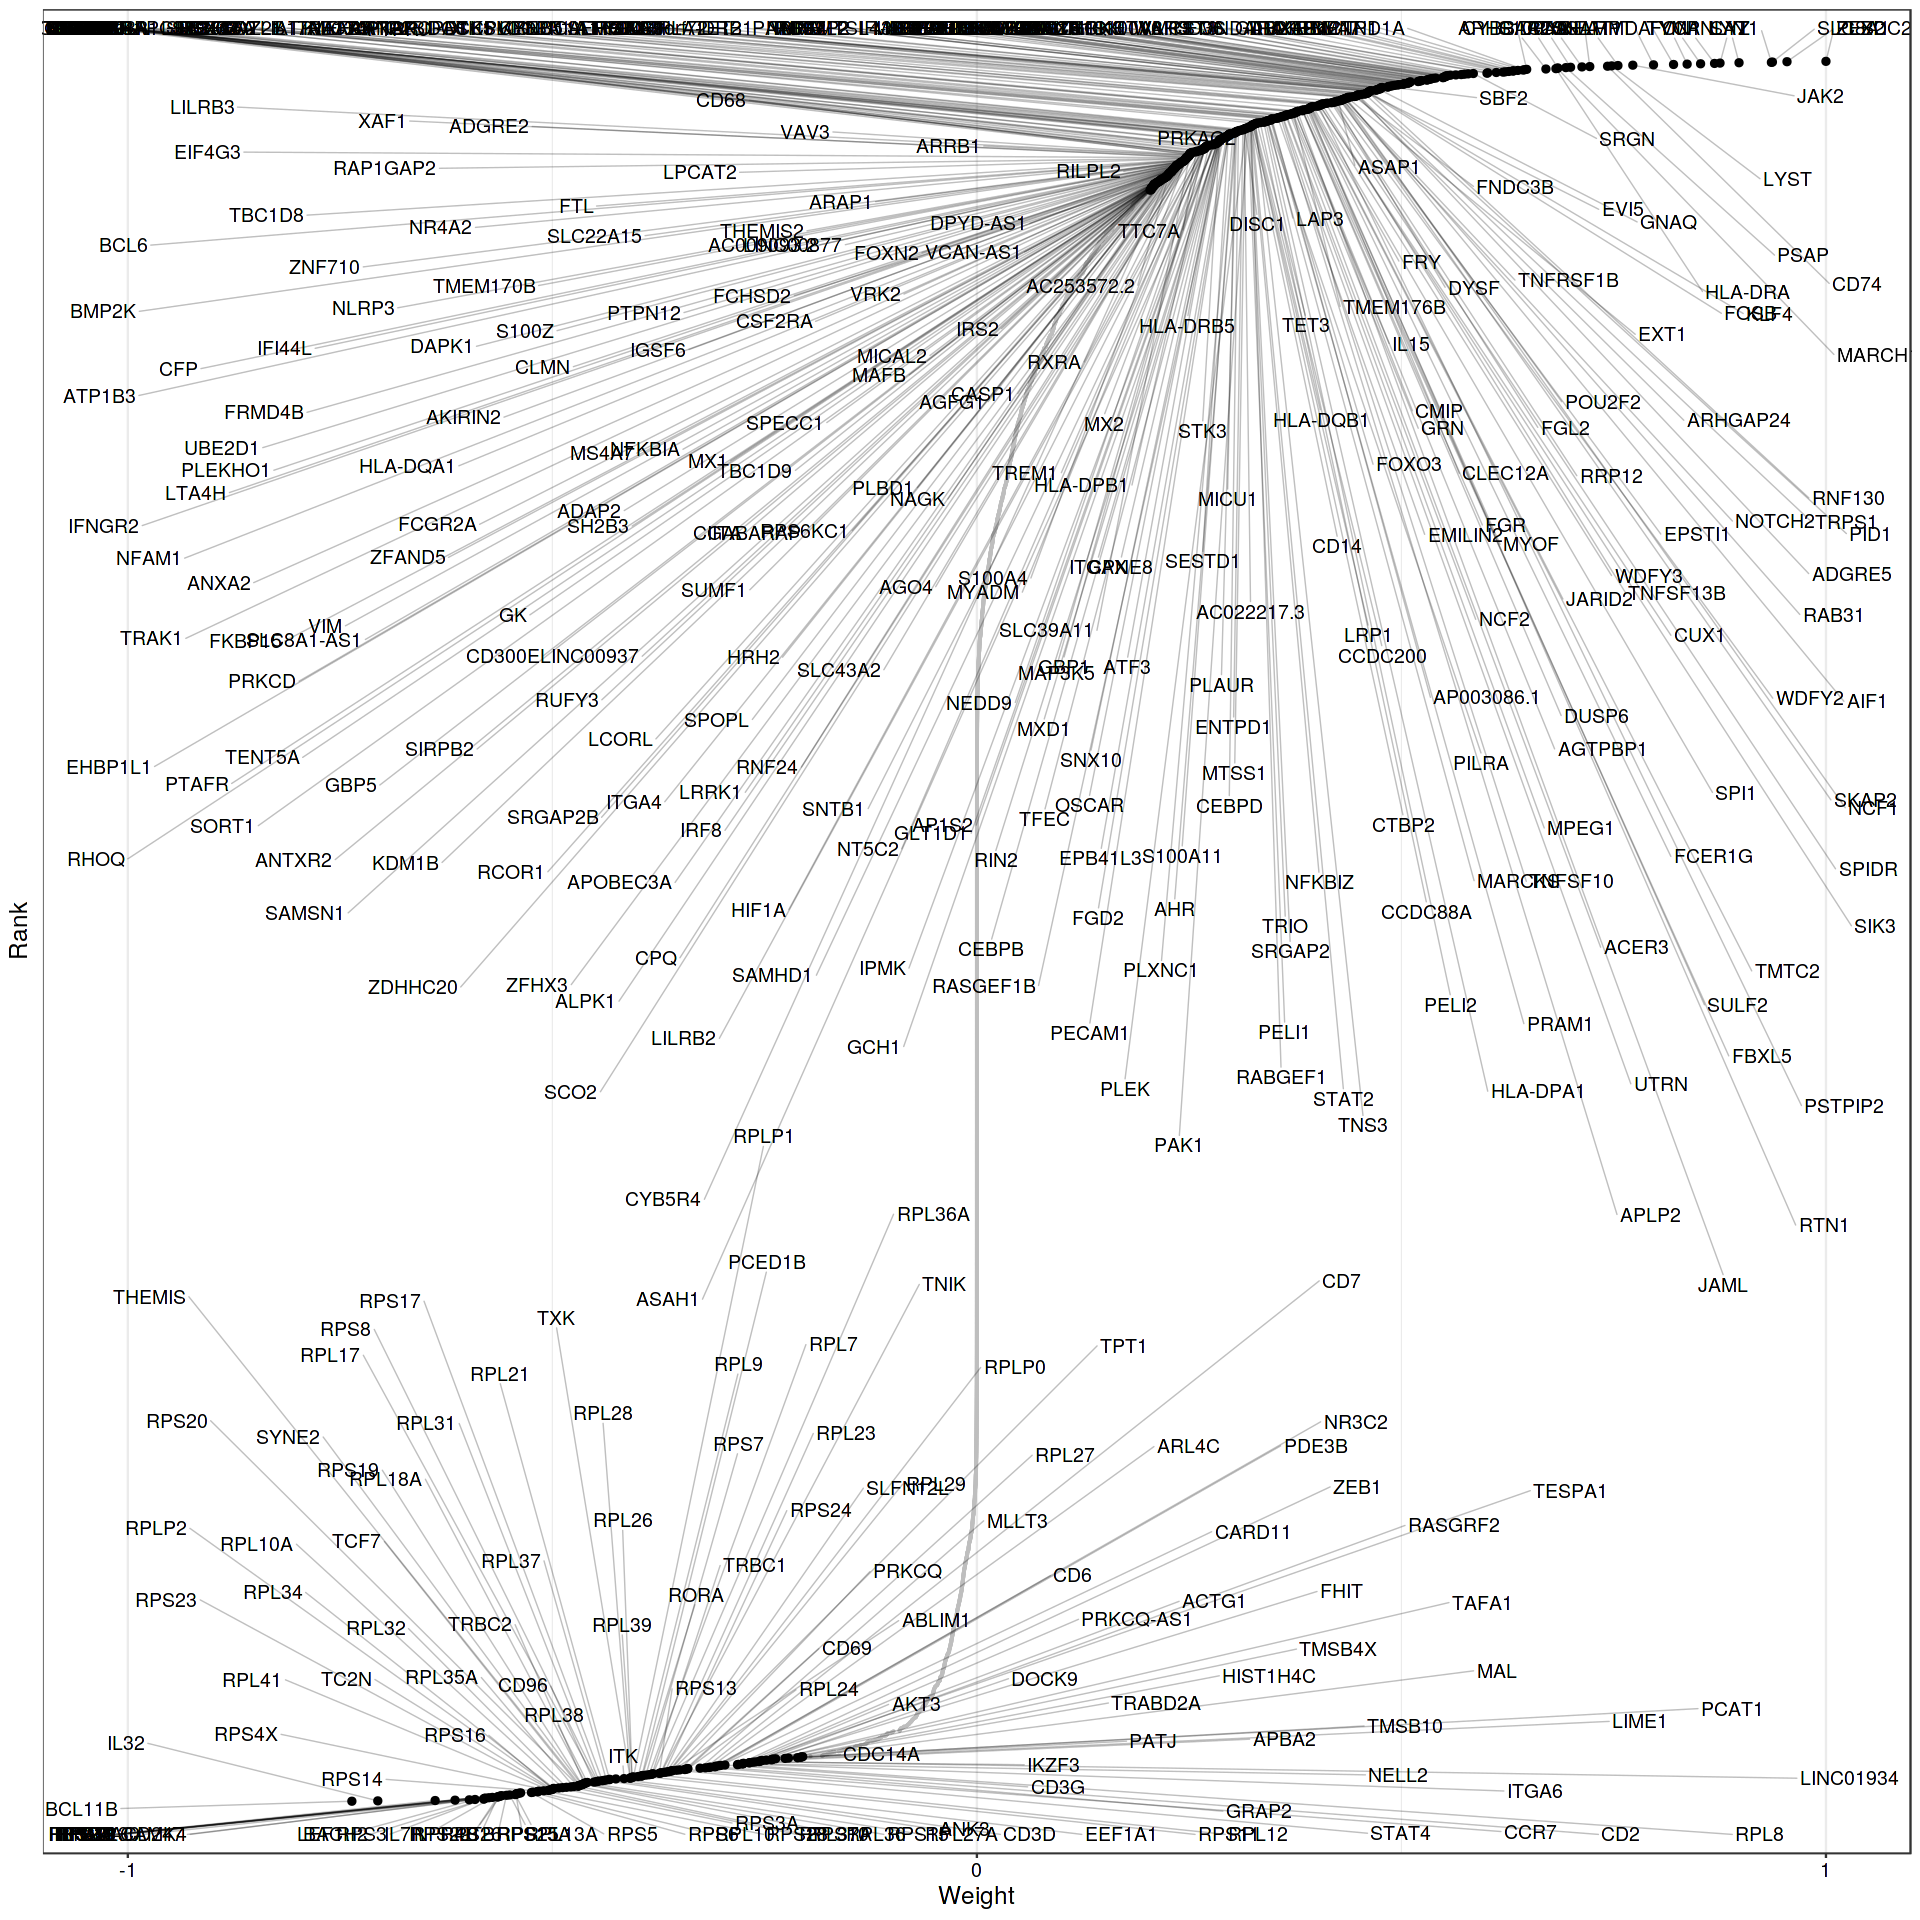

In [20]:
options(repr.plot.width = 16, repr.plot.height = 16)
plot_weights(sortedMOFA, 
  view = "RNA", nfeatures = 500, text_size = 4,
  factors = 1)

In [21]:
plot_weights(sortedMOFA, 
  view = "RNA", nfeatures = 500,
  factors = 1, return_data = TRUE)


,feature,view,factor,value,labelling_group,feature_id,labelling_indicator,color_by,shape_by
,<fct>,<fct>,<fct>,<dbl>,<chr>,<fct>,<fct>,<chr>,<chr>
Factor1.1186,BCL11B,RNA,Factor1,-0.7361406,1,BCL11B_Factor1,TRUE,1,1
Factor1.2527,IL32,RNA,Factor1,-0.7056075,1,IL32_Factor1,TRUE,1,1
Factor1.3984,RPS27,RNA,Factor1,-0.6380643,1,RPS27_Factor1,TRUE,1,1
Factor1.3985,RPS27A,RNA,Factor1,-0.6146296,1,RPS27A_Factor1,TRUE,1,1
Factor1.1319,CAMK4,RNA,Factor1,-0.5978295,1,CAMK4_Factor1,TRUE,1,1
Factor1.2745,LEF1,RNA,Factor1,-0.5911005,1,LEF1_Factor1,TRUE,1,1
Factor1.1170,BACH2,RNA,Factor1,-0.5807864,1,BACH2_Factor1,TRUE,1,1
Factor1.3989,RPS3,RNA,Factor1,-0.5805562,1,RPS3_Factor1,TRUE,1,1
Factor1.1421,CD247,RNA,Factor1,-0.5798975,1,CD247_Factor1,TRUE,1,1


In [24]:
topFeat3KSorted1245 <- plot_weights(sortedMOFA, 
  nfeatures = 100,
  factors = c(1,2,4,5), return_data = TRUE)

saveRDS(topFeat3KSorted1245, "topFeat3KSorted1245.rds")

In [25]:
topFeat3kUnsorted1245 <- plot_weights(unsortedMOFA, 
  nfeatures = 100,
  factors = c(1,2,4,5), return_data = TRUE)

saveRDS(topFeat3kUnsorted1245, "topFeat3kUnsorted1245.rds")

In [26]:
topFeat3kUnsorted1245

,feature,view,factor,value,labelling_group,feature_id,labelling_indicator,color_by,shape_by
,<fct>,<fct>,<fct>,<dbl>,<chr>,<fct>,<fct>,<chr>,<chr>
Factor1.4976,BCL11B,RNA,Factor1,-0.7589493,1,BCL11B_Factor1,TRUE,1,1
Factor1.16642,SKAP1,RNA,Factor1,-0.6856183,1,SKAP1_Factor1,TRUE,1,1
Factor1.4913,BACH2,RNA,Factor1,-0.6532589,1,BACH2_Factor1,TRUE,1,1
Factor1.10980,LEF1,RNA,Factor1,-0.6437343,1,LEF1_Factor1,TRUE,1,1
Factor1.5484,CAMK4,RNA,Factor1,-0.6390787,1,CAMK4_Factor1,TRUE,1,1
Factor1.4980,BCL2,RNA,Factor1,-0.6111791,1,BCL2_Factor1,TRUE,1,1
Factor1.14852,PRKCH,RNA,Factor1,-0.6043035,1,PRKCH_Factor1,TRUE,1,1
Factor1.5837,CD247,RNA,Factor1,-0.5880212,1,CD247_Factor1,TRUE,1,1
Factor1.10258,INPP4B,RNA,Factor1,-0.5531757,1,INPP4B_Factor1,TRUE,1,1


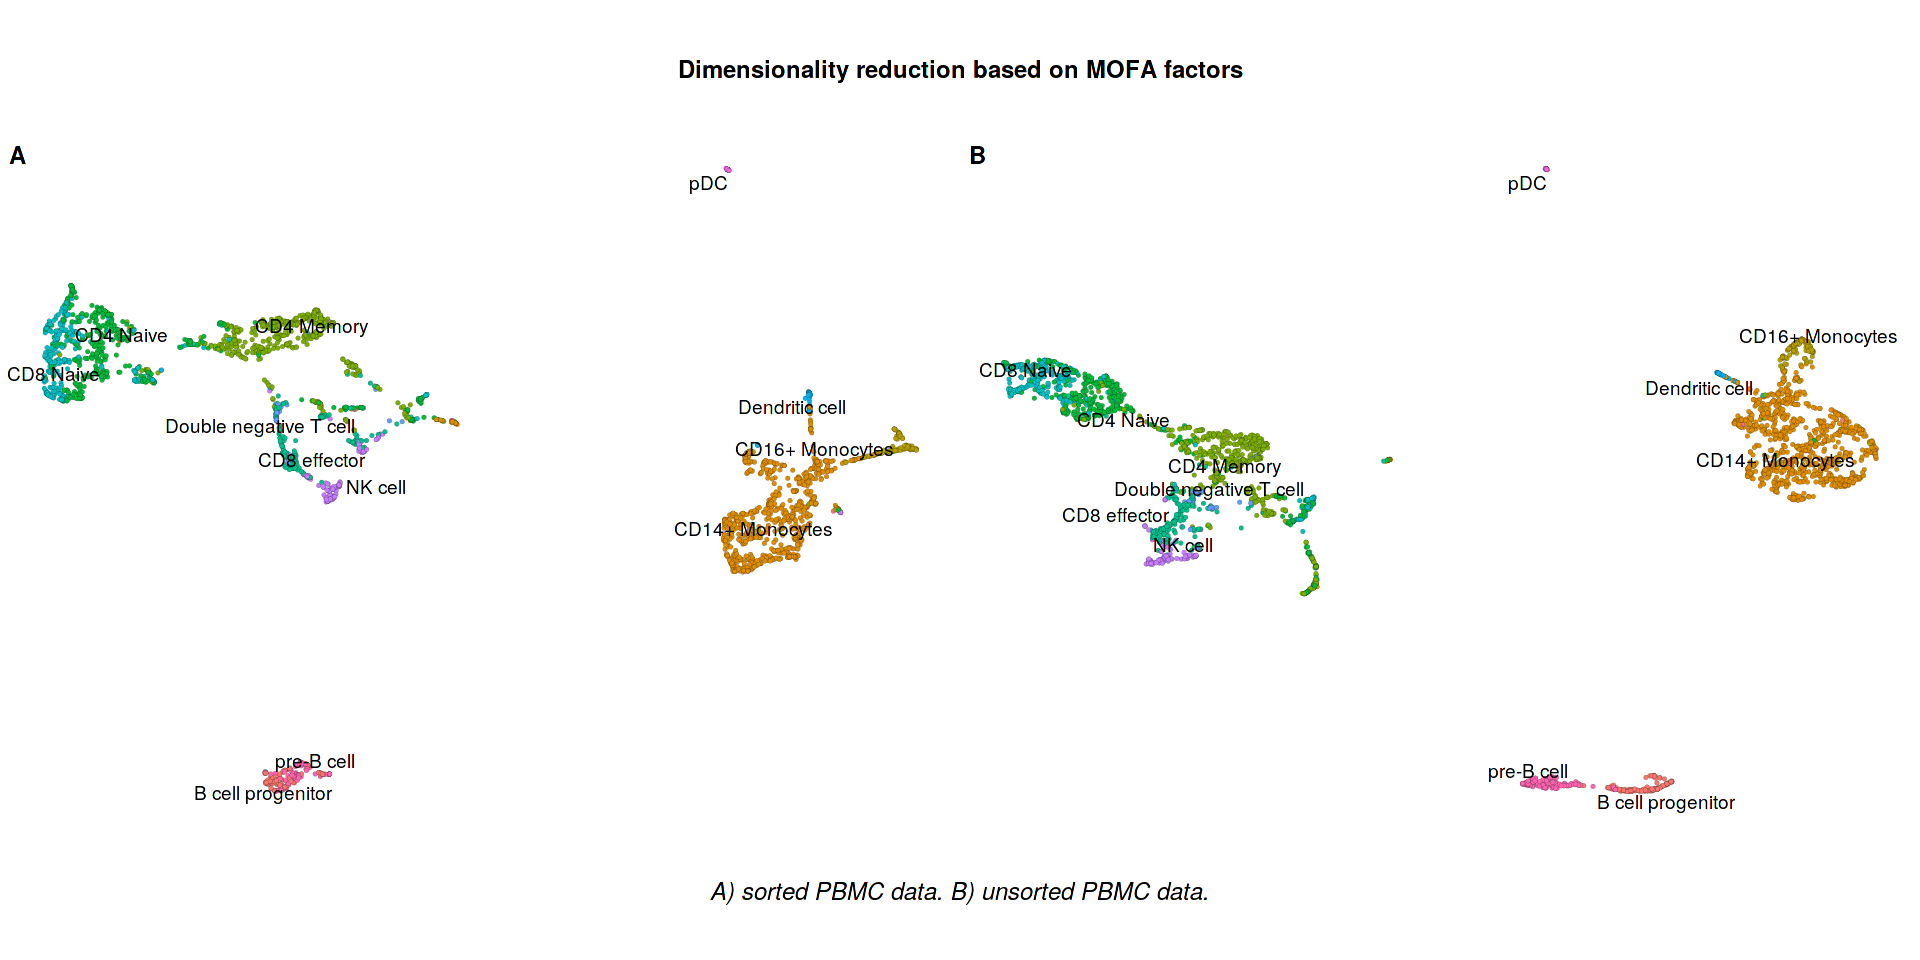

In [28]:
options(repr.plot.width = 16, repr.plot.height = 8)

suppressMessages({
    factors <- 1:get_dimensions(sortedMOFA)[["K"]]

    mofa <- run_umap(sortedMOFA, 
      factors = factors, 
      n_neighbors = 8,  
      min_dist = 0.30
    )

    a <- plot_dimred(sortedMOFA, 
      method = "UMAP", 
      color_by = "celltype", 
      label = TRUE, 
      stroke=0.05, 
      dot_size = 1, 
      legend = FALSE
    ) + theme_void() + theme(legend.position="none")

    factors <- 1:get_dimensions(unsortedMOFA)[["K"]]

    mofa <- run_umap(unsortedMOFA, 
      factors = factors, 
      n_neighbors = 8,  
      min_dist = 0.30
    )

    b <- plot_dimred(unsortedMOFA, 
      method = "UMAP", 
      color_by = "celltype", 
      label = TRUE, 
      stroke=0.05, 
      dot_size = 1, 
      legend = FALSE
    ) + theme_void() + theme(legend.position="none")

    plot <- cowplot::plot_grid(a, b, labels = "AUTO", nrow = 1)

    title   <- ggdraw() + draw_label(
        "Dimensionality reduction based on MOFA factors",
        fontface = 'bold') 

    caption <- ggdraw() + draw_label(
        "A) sorted PBMC data. B) unsorted PBMC data.",
        fontface = 'italic') 

    cowplot::plot_grid(title, plot, caption, ncol = 1, rel_heights = c(0.2, 1, 0.2))
})

In [36]:
factors <- 1:get_dimensions(sortedMOFA)[["K"]]

mofa <- run_umap(sortedMOFA, 
      factors = factors, 
      n_neighbors = 8,  
      min_dist = 0.30
)

a <- plot_dimred(sortedMOFA, 
      method = "UMAP", 
      color_by = "celltype", 
      label = TRUE, 
      stroke=0.05, 
      dot_size = 1, 
      legend = FALSE,
      return_data = TRUE
) #+ theme_void() + theme(legend.position="none")

UMAP embedding was not computed. Running run_umap()...



In [39]:
run_umap(sortedMOFA, 
      factors = factors, 
      n_neighbors = 8,  
      min_dist = 0.30
)


Trained MOFA with the following characteristics: 
 Number of views: 3 
 Views names: RNA ATAC_distal ATAC_promoter 
 Number of features (per view): 5000 854 7070 
 Number of groups: 1 
 Groups names: group1 
 Number of samples (per group): 2714 
 Number of factors: 15 


In [50]:
a <- MOFA2::run_umap(sortedMOFA)

In [51]:
a@dim_red


sample,UMAP1,UMAP2
<chr>,<dbl>,<dbl>
AAACAGCCAAATATCC-1,-3.77054229,-2.5975042
AAACAGCCAGGAACTG-1,10.90322122,-2.8126956
AAACAGCCAGGCTTCG-1,9.34312734,1.0518858
AAACCAACACCTGCTC-1,-4.80891171,-11.8595937
AAACCAACAGATTCAT-1,-4.46330204,-1.7985911
AAACCAACAGTTGCGT-1,-8.45000544,3.3590542
AAACCAACATAACGGG-1,-2.18591800,3.9498006
AAACCAACATAGACCC-1,10.70335302,0.1000735
AAACCGCGTGAGGTAG-1,-4.35151806,-12.4474462


In [37]:
sortedMOFA@

sample,color_by,shape_by,observed,x,y
<chr>,<chr>,<chr>,<fct>,<dbl>,<dbl>
AAACAGCCAAATATCC-1,NK cell,1,TRUE,-2.5889386,-1.92805417
AAACAGCCAGGAACTG-1,CD14+ Monocytes,1,TRUE,10.9628679,-3.15874167
AAACAGCCAGGCTTCG-1,CD14+ Monocytes,1,TRUE,10.0757447,1.10146253
AAACCAACACCTGCTC-1,pre-B cell,1,TRUE,-5.8795413,-13.01263566
AAACCAACAGATTCAT-1,CD8 effector,1,TRUE,-3.5259315,-1.47070129
AAACCAACAGTTGCGT-1,CD4 Naive,1,TRUE,-8.5366696,4.21268706
AAACCAACATAACGGG-1,CD4 Memory,1,TRUE,-2.6431688,4.25004392
AAACCAACATAGACCC-1,CD14+ Monocytes,1,TRUE,9.3099557,-0.58020814
AAACCGCGTGAGGTAG-1,pre-B cell,1,TRUE,-6.3190445,-12.45931668


In [34]:
str(mofa)

Formal class 'MOFA' [package "MOFA2"] with 16 slots
  ..@ data              :List of 3
  .. ..$ RNA          :List of 1
  .. .. ..$ group1: num [1:5000, 1:2714] 0.9943 -0.1134 -0.2967 4.2078 -0.0547 ...
  .. .. .. ..- attr(*, "dimnames")=List of 2
  .. .. .. .. ..$ : chr [1:5000(1d)] "IGLC2" "CDKN1C" "TCF4" "GNLY" ...
  .. .. .. .. ..$ : chr [1:2714(1d)] "AAACAGCCAAATATCC-1" "AAACAGCCAGGAACTG-1" "AAACAGCCAGGCTTCG-1" "AAACCAACACCTGCTC-1" ...
  .. ..$ ATAC_distal  :List of 1
  .. .. ..$ group1: num [1:854, 1:2714] 0.609 0.791 -0.769 -0.756 0.147 ...
  .. .. .. ..- attr(*, "dimnames")=List of 2
  .. .. .. .. ..$ : chr [1:854(1d)] "chr16-22188045-22200075" "chr9-129874830-129899878" "chr10-72314938-72337885" "chr2-136122482-136138662" ...
  .. .. .. .. ..$ : chr [1:2714(1d)] "AAACAGCCAAATATCC-1" "AAACAGCCAGGAACTG-1" "AAACAGCCAGGCTTCG-1" "AAACCAACACCTGCTC-1" ...
  .. ..$ ATAC_promoter:List of 1
  .. .. ..$ group1: num [1:7070, 1:2714] 0.135 -0.0315 -0.292 0.15 -0.1223 ...
  .. .. .. ..- att